
Dataset 1 Results:
Accuracy: 0.9067, F1 Score: 0.9014

Dataset 2 Results:
Accuracy: 0.8884, F1 Score: 0.8878


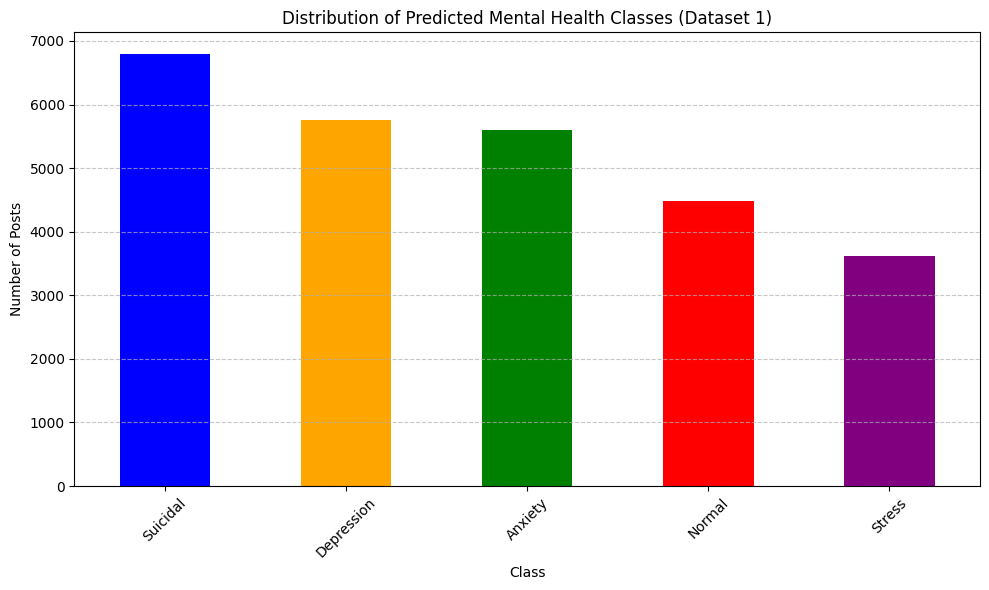

In [ ]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score  # New imports for metrics

# Load the fine-tuned model and tokenizer
model_path = "/content/drive/MyDrive/fine_tuned_marbert_V3"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define label mapping (ensure it matches the training labels)
label_mapping = {
    0: 'Normal',
    1: 'Anxiety',
    2: 'Depression',
    3: 'Suicidal',
    4: 'Stress'
}

# ===== Dataset 1 =====
input_file1 = "/content/drive/MyDrive/cleaned_mental_health_dataset.xlsx"
df_posts1 = pd.read_excel(input_file1)
df_posts1 = df_posts1.dropna().reset_index(drop=True)

# Function to classify posts
def classify_post(statement):
    tokens = tokenizer(statement, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    tokens = {key: value.to(device) for key, value in tokens.items()}
    with torch.no_grad():
        outputs = model(**tokens)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return label_mapping[prediction]

# Classify Dataset 1
df_posts1['predicted_label'] = df_posts1['statement'].apply(classify_post)

# ===== Dataset 2 =====
input_file2 = "/content/drive/MyDrive/cleaned_original_dataset.xlsx"  # REPLACE WITH YOUR ACTUAL PATH
df_posts2 = pd.read_excel(input_file2)
df_posts2 = df_posts2.dropna().reset_index(drop=True)
df_posts2['predicted_label'] = df_posts2['statement'].apply(classify_post)

# ===== Evaluation Metrics =====
def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return accuracy, f1

# Calculate metrics for both datasets
acc1, f1_1 = calculate_metrics(df_posts1['label'], df_posts1['predicted_label'])
acc2, f1_2 = calculate_metrics(df_posts2['label'], df_posts2['predicted_label'])

# Print results
print(f"\nDataset 1 Results:")
print(f"Accuracy: {acc1:.4f}, F1 Score: {f1_1:.4f}")
print(f"\nDataset 2 Results:")
print(f"Accuracy: {acc2:.4f}, F1 Score: {f1_2:.4f}")

# ===== Original Visualization (for Dataset 1) =====
class_counts = df_posts1['predicted_label'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title("Distribution of Predicted Mental Health Classes (Dataset 1)")
plt.xlabel("Class")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()